# IS318 - Machine Learning
## TP2 - Linear classification

The goal of this TP is to experiment with linear models for classification.

Completed by Mohamed Kherraz and Thomas Trenty. 

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity

### 1. Dataset

We will work with a synthetic binary classification dataset:

X shape: (500, 2)
y shape: (500,)
y unique values: [0 1]


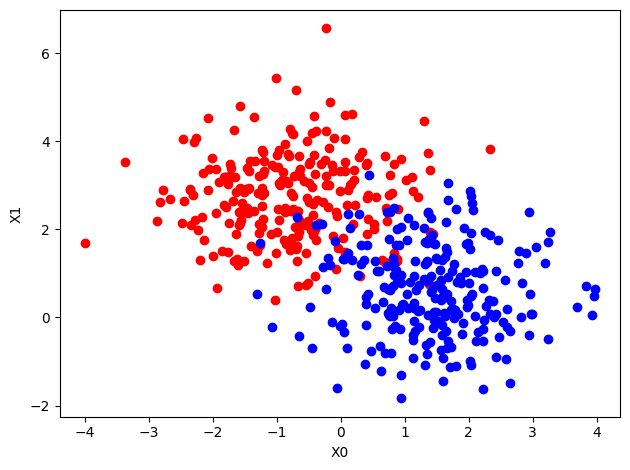

In [26]:
X, y = make_blobs(n_samples=500, n_features=2, centers=2, center_box=(-3, 3), random_state=42) # Easy
# X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2, random_state=0) # Harder

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"y unique values: {np.unique(y)}")

plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], color='red')
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], color='blue')
plt.xlabel('X0')
plt.ylabel('X1')
plt.tight_layout()
plt.show()

Analyzing the distribution of the data points for each group, by feature:

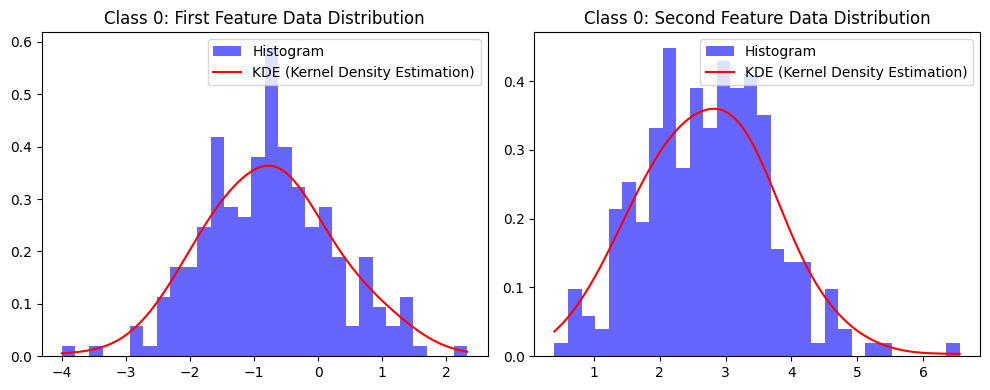

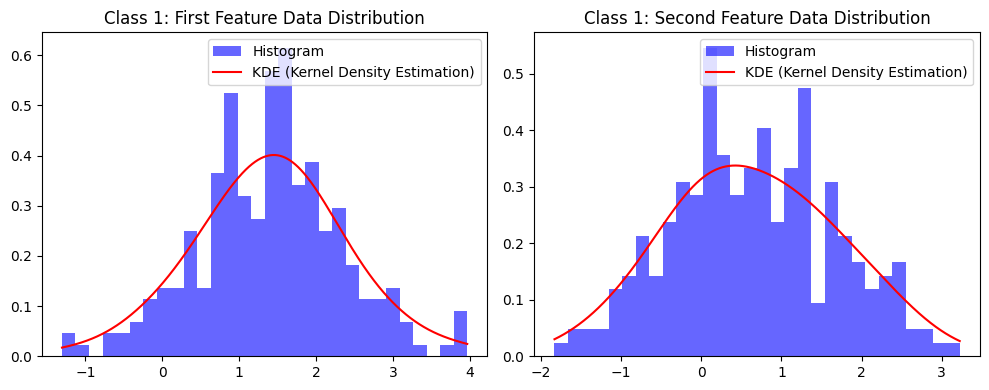

In [27]:
def plot_hist_kde(data, ax, title):
    # Plot histogram
    ax.hist(data, bins=30, density=True, alpha=0.6, color='b', label='Histogram')

    # Plot KDE
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data[:, np.newaxis])
    x_vals = np.linspace(min(data), max(data), 1000)
    log_dens = kde.score_samples(x_vals[:, np.newaxis])
    ax.plot(x_vals, np.exp(log_dens), color='r', label='KDE (Kernel Density Estimation)')
    
    ax.set_title(title)
    ax.legend()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_hist_kde(X[:, 0][y == 0], ax[0], "Class 0: First Feature Data Distribution")
plot_hist_kde(X[:, 1][y == 0], ax[1], "Class 0: Second Feature Data Distribution")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_hist_kde(X[:, 0][y == 1], ax[0], "Class 1: First Feature Data Distribution")
plot_hist_kde(X[:, 1][y == 1], ax[1], "Class 1: Second Feature Data Distribution")
plt.tight_layout()
plt.show()

These histograms show that our classes both follow sort of a gaussian distribution. This information will be usefull later in this notebook.

Before implementing a classification method, we will apply some preprocessing steps.

**(Question)** Preprocessing: normalize the data such that it has zero mean and unit variance. To do that, for each feature, substract the mean and divide by the standard deviation over the samples. Plot the data.

This procedure is called *standardization*.
It is useful for numerical stability (notably for gradient descent).

Means of X features: [4.26325641e-17 3.99680289e-17]
Variances of X features: [1. 1.]


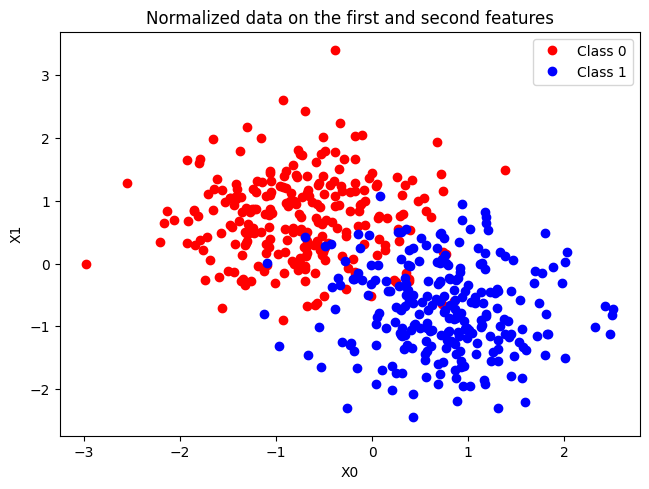

In [28]:
X_old = X.copy()
X = (X - X.mean(axis=0)) / X.std(axis=0)

print(f"Means of X features: {X.mean(axis=0)}")
print(f"Variances of X features: {X.std(axis=0)}")

plt.figure()
plt.title("Normalized data on the first and second features")
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'o', color='red', label='Class 0')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'o', color='blue', label='Class 1')
plt.tight_layout()
plt.legend()
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

In [29]:
assert np.allclose(X.mean(axis=0), 0.)
assert np.allclose(X.var(axis=0), 1.)

**(Question)** Plot the data points as above to observe the difference of standardization.

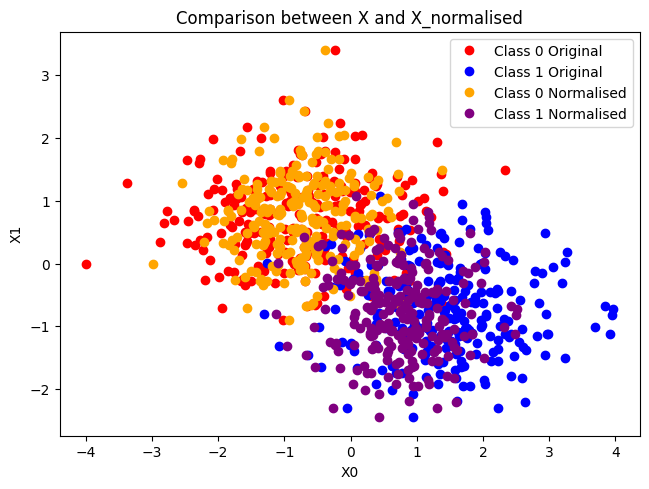

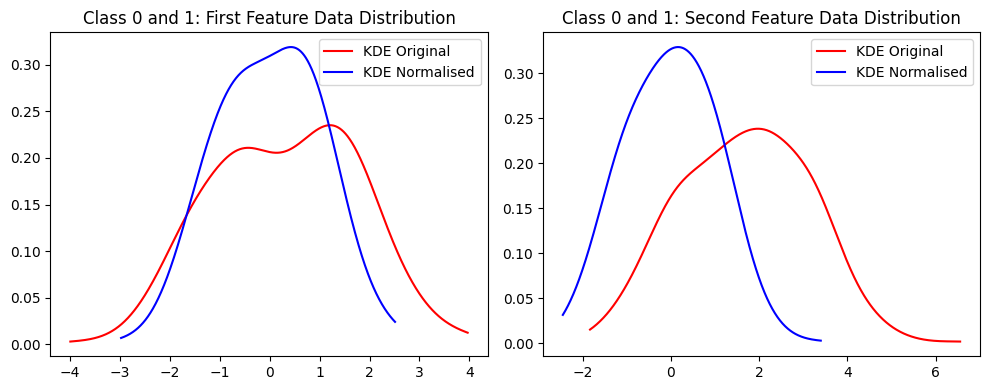

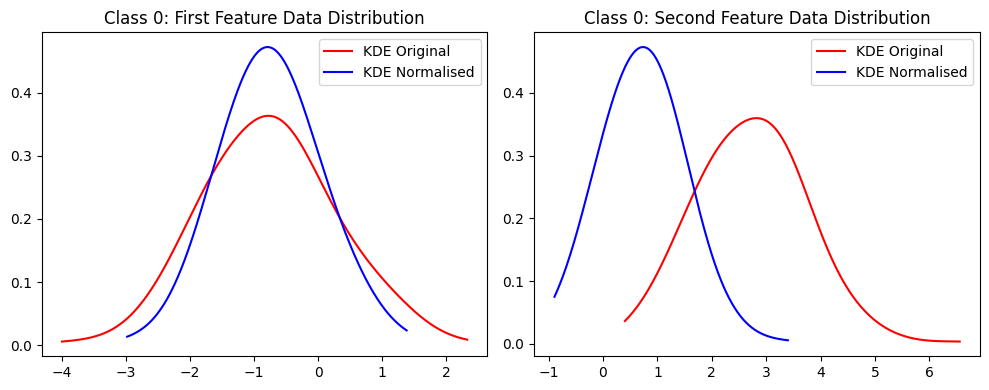

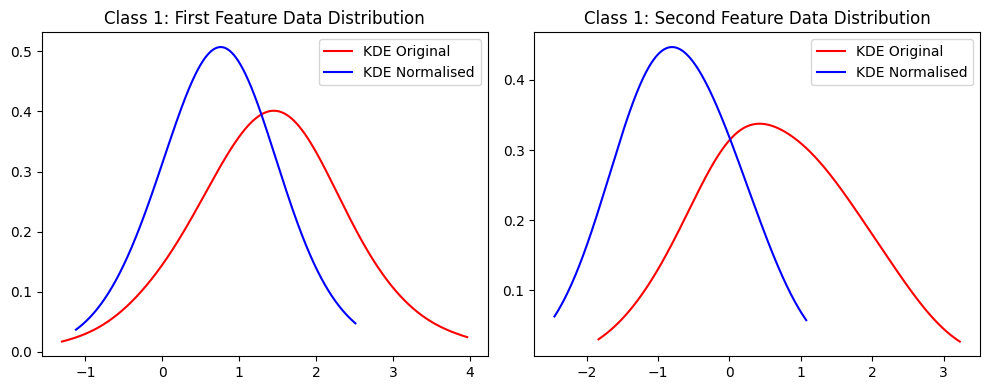

In [30]:
plt.figure()
plt.title("Comparison between X and X_normalised")
plt.plot(X_old[:, 0][y == 0], X[:, 1][y == 0], 'o', color='red', label='Class 0 Original')
plt.plot(X_old[:, 0][y == 1], X[:, 1][y == 1], 'o', color='blue', label='Class 1 Original')
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'o', color='orange', label='Class 0 Normalised')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'o', color='purple', label='Class 1 Normalised')
plt.legend()
plt.tight_layout()
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

def plot_diff_kde(data1, data2, ax, title):
        # Plot KDE
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data1[:, np.newaxis])
    x_vals = np.linspace(min(data1), max(data1), 1000)
    log_dens = kde.score_samples(x_vals[:, np.newaxis])
    ax.plot(x_vals, np.exp(log_dens), color='r', label='KDE Original')

    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data2[:, np.newaxis])
    x_vals = np.linspace(min(data2), max(data2), 1000)
    log_dens = kde.score_samples(x_vals[:, np.newaxis])
    ax.plot(x_vals, np.exp(log_dens), color='b', label='KDE Normalised')
    
    ax.set_title(title)
    ax.legend()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_diff_kde(X_old[:, 0], X[:, 0], ax[0], "Class 0 and 1: First Feature Data Distribution")
plot_diff_kde(X_old[:, 1], X[:, 1], ax[1], "Class 0 and 1: Second Feature Data Distribution")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_diff_kde(X_old[:, 0][y == 0], X[:, 0][y == 0], ax[0], "Class 0: First Feature Data Distribution")
plot_diff_kde(X_old[:, 1][y == 0], X[:, 1][y == 0], ax[1], "Class 0: Second Feature Data Distribution")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_diff_kde(X_old[:, 0][y == 1], X[:, 0][y == 1], ax[0], "Class 1: First Feature Data Distribution")
plot_diff_kde(X_old[:, 1][y == 1], X[:, 1][y == 1], ax[1], "Class 1: Second Feature Data Distribution")
plt.tight_layout()
plt.show()

After normalization, the data clusters will still follow a Gaussian distribution, as the transformations applied were linear. The dataset has been normalized globally on the two clusters, causing the two clusters to move closer to each other. This normalization appears to have reduced the sparsity of outliers on the first feature.

**(Question)** As usual, add a column with ones to simplify dot product notation. Then, split the dataset into training and validation sets.

In [31]:
X = np.hstack([np.ones((X.shape[0], 1)), X])

train_ratio = 0.8
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_ratio, random_state=42)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")

Train size: 400
Validation size: 100


In [32]:
assert X.shape[1] == 3
assert np.all(X[:, 0] == 1.)

**(Question)** With real data, it is considered wrong to apply standardization before splitting the dataset. Can you explain why?

Yes, standardizing the data before splitting the dataset in train/validation and test is usually considered wrong because it introduces information from the test set into the training process. To properly evaluate a model on unseen data, we must ensure that no information from the test set influences the training process.

When standardizing data, we should compute the mean and standard deviation only on the training set, and then apply those same values to the validation and test sets. This ensures that the test data is processed in the same way as the training data, without introducing any bias or prior knowledge from the validation and test sets during model training.

### 2. Logistic regression

**(Question)** Complete the `LogisticRegression` class below to implement logistic regression for binary classification.
- For the `fit` method, implement a simple gradient descent on the binary cross entropy loss. Record the evolution of the loss over the iterations in the `loss_hist` attribute.
- For the `predict` method, compute predictions from the model and return the binary decisions by thresholding at $0.5$.

In [33]:
class LogisticRegression():
    
    def __init__(self, learning_rate=0.1, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.loss_hist = []
        self.params = None
           
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def binary_cross_entropy(self, y, y_pred):
        epsilon = 1e-15 # To avoid log(0)
        return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
        # return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        
    def fit(self, X, y):
        np.random.seed(0) 
        self.params = np.random.randn(X.shape[1])

        for _ in range(self.n_iters):
            # Forward pass
            y_pred = self.sigmoid(X @ self.params)

            # Loss computation
            loss = self.binary_cross_entropy(y, y_pred)
            self.loss_hist.append(loss)

            # Gradient computation
            grad = np.dot(X.T, (y_pred - y)) / len(y)

            # Update weights
            self.params -= self.learning_rate * grad
    
    def predict(self, X):
        return np.round(self.sigmoid(X @ self.params))
    
    def decision_function(self, X):
        return self.sigmoid(X @ self.params)

**(Question)** Apply your logistic regression model with default arguments to our synthetic dataset. Report the classification accuracy on the training and validation sets.

Model                                    Train Accuracy       Validation Accuracy 
----------------------------------------------------------------------
Our Logistic Regression model            0.935                0.960               


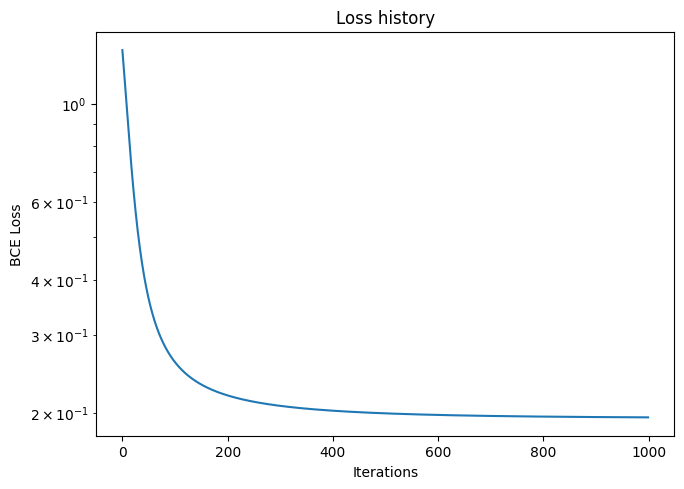

In [34]:
classifier = LogisticRegression()

classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)

LR_train_accuracy = np.mean(y_train_pred == y_train)
LR_val_accuracy = np.mean(y_val_pred == y_val)

print(f"{'Model':<40} {'Train Accuracy':<20} {'Validation Accuracy':<20}")
print(f"{'-'*70}")
print(f"{'Our Logistic Regression model':<40} {LR_train_accuracy:<20.3f} {LR_val_accuracy:<20.3f}")

plt.plot(classifier.loss_hist)
plt.title("Loss history")
plt.tight_layout()
plt.yscale('log')
plt.ylabel("BCE Loss")
plt.xlabel("Iterations")
plt.show()

**(Question)** Plot the decision boundary on top on the data points.

*Hint*: to compute the decision boundary, start from its equation and transform it to an usual affine formulation.

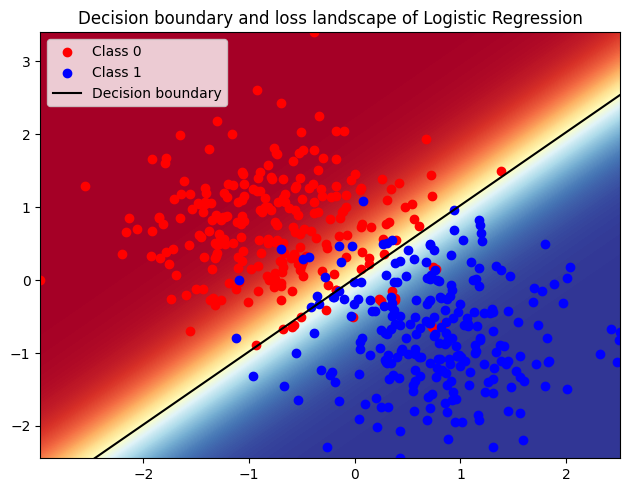

In [35]:
def get_x0_x1_min_max_from_params(w, b, x0_min=-3, x0_max=3, x1_min=-3, x1_max=3):
    """
    Decision boundary: w0 + w1*x1 + w2*x2 = 0
    x1 = (-w0 - w2*x2) / w1
    x2 = (-w0 - w1*x1) / w2
    We will fix x1 or x2 to compute the other one for the decision boundary
    """
    
    x0_min_barrier = x0_min
    x1_min_barrier = (-b - w[0] * x0_min_barrier) / w[1]
    if x1_min_barrier < x1_min:
        x1_min_barrier = x1_min
        x0_min_barrier = (-b - w[1] * x1_min_barrier) / w[0]

    x0_max_barrier = x0_max
    x1_max_barrier = (-b - w[0] * x0_max_barrier) / w[1]
    if x1_max_barrier > x1_max:
        x1_max_barrier = x1_max
        x0_max_barrier = (-b - w[1] * x1_max_barrier) / w[0]

    return x0_min_barrier, x1_min_barrier, x0_max_barrier, x1_max_barrier

def plot_loss_landscape(classifier, X, y, get_w_and_b, model_name, remove_column0_X=False, grid_size=100, no_ones=False):
    """
    Plot the decision boundary and the loss landscape of the classifier
    """
    if no_ones:
        x0_min, x0_max = X[:, 0].min(), X[:, 0].max()
        x1_min, x1_max = X[:, 1].min(), X[:, 1].max()
    else :
        x0_min, x0_max = X[:, 1].min(), X[:, 1].max()
        x1_min, x1_max = X[:, 2].min(), X[:, 2].max()


    xx0, xx1 = np.meshgrid(np.linspace(x0_min, x0_max, grid_size), np.linspace(x1_min, x1_max, grid_size))

    if remove_column0_X:
        X_grid = np.hstack([xx0.ravel()[:, None], xx1.ravel()[:, None]])
    else:
        X_grid = np.hstack([np.ones((grid_size**2, 1)), xx0.ravel()[:, None], xx1.ravel()[:, None]])
    
    y_grid = classifier.decision_function(X_grid)

    w, b = get_w_and_b(classifier)

    x0_min_barrier, x1_min_barrier, x0_max_barrier, x1_max_barrier = get_x0_x1_min_max_from_params(w, b, x0_min, x0_max, x1_min, x1_max)

    if isinstance(x0_min_barrier, np.ndarray):
        x0_min_barrier = x0_min_barrier[0]
    if isinstance(x1_min_barrier, np.ndarray):
        x1_min_barrier = x1_min_barrier[0]
    if isinstance(x0_max_barrier, np.ndarray):
        x0_max_barrier = x0_max_barrier[0]
    if isinstance(x1_max_barrier, np.ndarray):
        x1_max_barrier = x1_max_barrier[0]


    decision_boundary = np.array([[x0_min_barrier, x1_min_barrier], [x0_max_barrier, x1_max_barrier]])

    plt.figure()
    plt.contourf(xx0, xx1, y_grid.reshape(grid_size, grid_size), alpha=1, cmap='RdYlBu', levels=500)
    if no_ones:
        plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], color='red', label='Class 0')
        plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], color='blue', label='Class 1')
    else:
        plt.scatter(X[:, 1][y == 0], X[:, 2][y == 0], color='red', label='Class 0')
        plt.scatter(X[:, 1][y == 1], X[:, 2][y == 1], color='blue', label='Class 1')
    plt.plot(decision_boundary[:, 0], decision_boundary[:, 1], color='black', label="Decision boundary")
    plt.tight_layout()
    plt.legend()
    plt.title(f"Decision boundary and loss landscape of {model_name}")
    plt.show()

    return decision_boundary

def LR_get_w_and_b(classifier):
    return classifier.params[1:], classifier.params[0]

grid_size = 100
LR_decision_boundary = plot_loss_landscape(classifier, X, y, LR_get_w_and_b, "Logistic Regression")

**(Question)** Play around with the `learning_rate` and `n_iters` hyperparameters to see the impact on gradient descent convergence.
Plot the evolution of the loss over the iterations for different learning rates.
Comment the results.

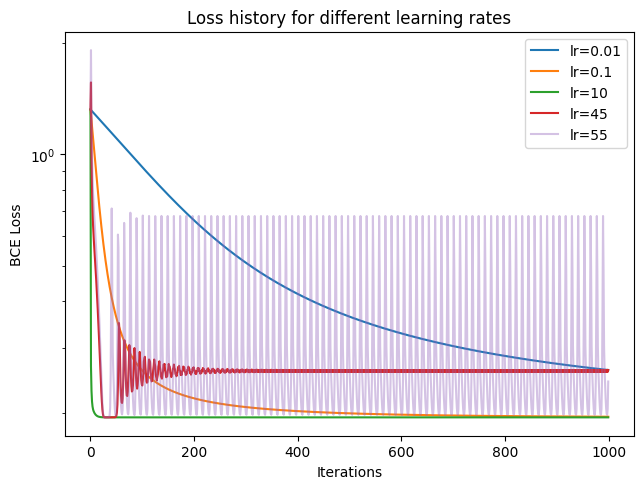

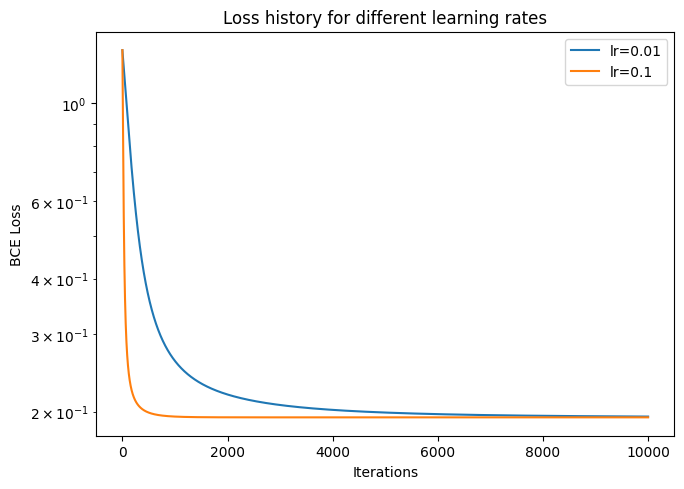

In [36]:
def plot_loss_history(X_train, y_train, lr_list, n_iters):
    loss_histories = []
    for lr in lr_list:
        classifier = LogisticRegression(learning_rate=lr, n_iters=n_iters)
        classifier.fit(X_train, y_train)
        loss_histories.append(classifier.loss_hist)

    plt.figure()
    for i, lr in enumerate(lr_list):
        alpha = 1
        if lr == 55: 
            alpha = 0.4
        plt.plot(loss_histories[i], label=f"lr={lr}", alpha=alpha)
    plt.title("Loss history for different learning rates")
    plt.tight_layout()
    plt.yscale('log')
    plt.ylabel("BCE Loss")
    plt.xlabel("Iterations")
    plt.legend()
    plt.show()

lr_list = [0.01, 0.1, 10, 45, 55]
n_iters = 1000

plot_loss_history(X_train, y_train, lr_list, n_iters)

lr_list = [0.01, 0.1]
n_iters = 10000

plot_loss_history(X_train, y_train, lr_list, n_iters)

The plot above shows the evolution of the BCE loss value for four different learning rates (lr). In blue, a learning rate of 0.01 is too small for the problem (logistic regression model + blobs dataset), making convergence unnecessarily slow. We can observe that with a learning rate of 0.1, convergence is faster and stable by iteration 1000, whereas with a learning rate of 0.01, it takes nearly 10,000 iterations to reach the same level of precision. Even for this specific problem (model + toy dataset), a learning rate of 10 works, converging in just a few iterations.

However, on the other hand, a learning rate that is too large, such as 45 or 55 in this case, leads to unstable training. With a learning rate of 45, the training stabilizes, but not at the minimum of the BCE loss curve. The steps/hops are too large, causing the model to oscillate from one side of the BCE loss graph to the other without moving closer to the optimal solution. With a learning rate of 55 or higher, the training process becomes extremely chaotic, and the model fails to converge to a solution. To comprehend the oscilation of the loss with a learning rate of 55 better, we propose the following explanation : the gradient descent starts at a point high in the curve then drops down to a point close to the minimum but it falls a bit short so it tries to move a bit closer but since the learning rate is too high, it overshoots and repeats this process indefinitely.



Note : It is important to note that with the given data and linear model, it impossible to reach a loss of 0 since the two classes mix in the middle section. Which explains why the loss stops at $2e-1$ even though the number of iteration is very high.

### 3. Gaussian generative model

Applying the Gaussian generative model on a dataset requires some hypotheses, such as considering that the data follows a Gaussian distribution. In our case, it is a rational choice to test the Gaussian model, since our data does in fact follow a Gaussian distribution.

**(Question)** Complete the `GaussianGenerativeModel` class below.

In [37]:
class GaussianGenerativeModel():
    w = None
    b = None

    def fit(self, X, y):
        N0 = np.sum(y == 0)
        N1 = np.sum(y == 1)

        X0 = X[y == 0]
        X1 = X[y == 1]

        # frequency of class 1 (prior)
        self.theta = N1 / (N0 + N1)

        # mean of class 0
        self.mu0 = np.mean(X0, axis=0)

        # mean of class 1
        self.mu1 = np.mean(X1, axis=0)

        # weighted mean of covariances
        self.sigma = 1 / (N0 + N1) * \
                        (
                            np.dot((X0 - self.mu0).T, X0 - self.mu0) 
                            + 
                            np.dot((X1 - self.mu1).T, X1 - self.mu1)
                        ) 

        self.w = np.dot(np.linalg.inv(self.sigma), self.mu1 - self.mu0)
        self.b = -0.5 * np.dot(self.mu1, np.dot(np.linalg.inv(self.sigma), self.mu1)) + 0.5 * np.dot(self.mu0, np.dot(np.linalg.inv(self.sigma), self.mu0)) + np.log(self.theta / (1 - self.theta))

        
    def predict(self, X):
        return np.round(LogisticRegression.sigmoid(None, np.dot(X, self.w) + self.b))
    
    def decision_function(self, X):
        return LogisticRegression.sigmoid(None, np.dot(X, self.w) + self.b)
        

**(Question)** Apply your gaussian generative model to our synthetic dataset. Report the classification accuracy on the training and validation sets.

*Hint:* The column with ones is not needed for this model.

In [38]:
X_train = X_train[:, 1:]
X_val = X_val[:, 1:]

GGM_classifier = GaussianGenerativeModel()
GGM_classifier.fit(X_train, y_train)

y_train_pred = GGM_classifier.predict(X_train)
y_val_pred = GGM_classifier.predict(X_val)

GGM_train_accuracy = np.mean(y_train_pred == y_train)
GGM_val_accuracy = np.mean(y_val_pred == y_val)

print(f"{'Model':<40} {'Train Accuracy':<20} {'Validation Accuracy':<20}")
print(f"{'-'*70}")
print(f"{'Our Gaussian Generative Model':<40} {GGM_train_accuracy:<20.3f} {GGM_val_accuracy:<20.3f}")

Model                                    Train Accuracy       Validation Accuracy 
----------------------------------------------------------------------
Our Gaussian Generative Model            0.930                0.960               


**(Question)** Plot the decision boundary on top on the data points and compare it with the one obtained with logistic regression.

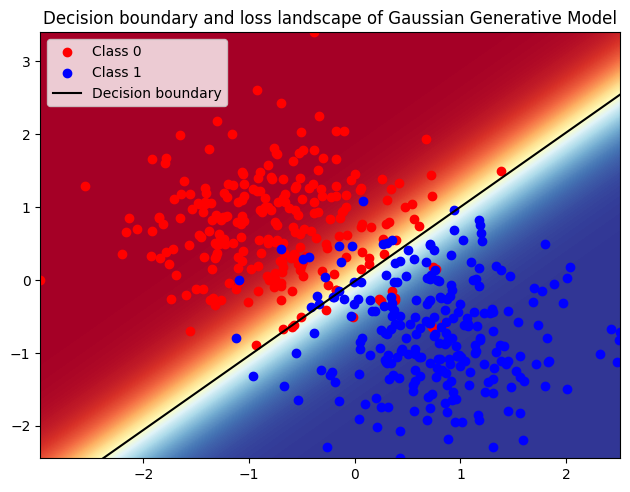

In [39]:
def GMM_get_w_and_b(classifier):
    return classifier.w, classifier.b

grid_size = 100
GGM_decision_boundary = plot_loss_landscape(GGM_classifier, X, y, GMM_get_w_and_b, "Gaussian Generative Model", remove_column0_X=True)

Model                                    Train Accuracy       Validation Accuracy 
----------------------------------------------------------------------
Our Logistic Regression model            0.935                0.960               
Our Gaussian Generative Model            0.930                0.960               


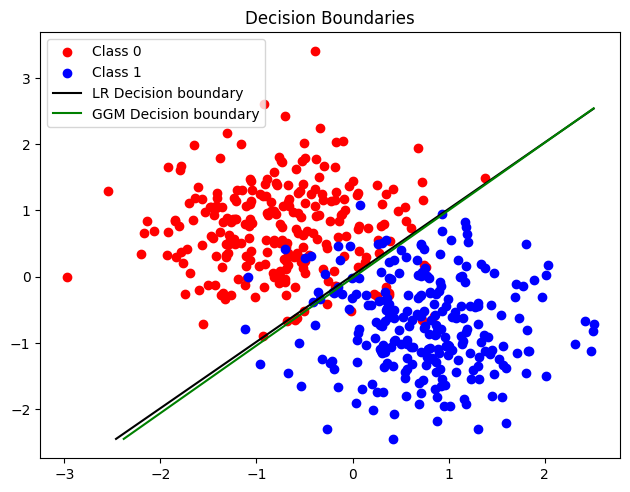

In [40]:
# Comparing the Logistic Regression and Gaussian Generative Performances
print(f"{'Model':<40} {'Train Accuracy':<20} {'Validation Accuracy':<20}")
print(f"{'-'*70}")
print(f"{'Our Logistic Regression model':<40} {LR_train_accuracy:<20.3f} {LR_val_accuracy:<20.3f}")
print(f"{'Our Gaussian Generative Model':<40} {GGM_train_accuracy:<20.3f} {GGM_val_accuracy:<20.3f}")

# Plotting the Logistic Regression and Gaussian Generative Model decision boundaries
plt.figure()
plt.scatter(X[:, 1][y == 0], X[:, 2][y == 0], color='red', label='Class 0')
plt.scatter(X[:, 1][y == 1], X[:, 2][y == 1], color='blue', label='Class 1')
plt.plot(LR_decision_boundary[:, 0], LR_decision_boundary[:, 1], color='black', label='LR Decision boundary')
plt.plot(GGM_decision_boundary[:, 0], GGM_decision_boundary[:, 1], color='green', label='GGM Decision boundary')
plt.tight_layout()
plt.legend()
plt.title("Decision Boundaries")
plt.show()

The difference between the two models is barely noticeable, as both achieved a testing score of 95.0%. They perform very similarly and fit a straight line that appears to indicate perfect separation for a linear model.

### 4. Comparison with `sklearn`

**(Question)** Apply logistic regression using the `LogisticRegression` class from the `scikit-learn` library. Compare the results with your previous implementation.

*Hints:*
- If your features are already augmented with a column of ones, set the `fit_intercept` parameter to `False`
- Set `penalty` (regularization to `None` to match your unregularized implementation

Model                                    Train Accuracy       Validation Accuracy 
----------------------------------------------------------------------
Our Logistic Regression model            0.935                0.960               
Our Gaussian Generative Model            0.930                0.960               
Sklearn Logistic Regression model        0.932                0.960               


/home/mkherraz001/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mkherraz001/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mkherraz001/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mkherraz001/miniconda3/lib/python3.12/site-packages/sklearn/

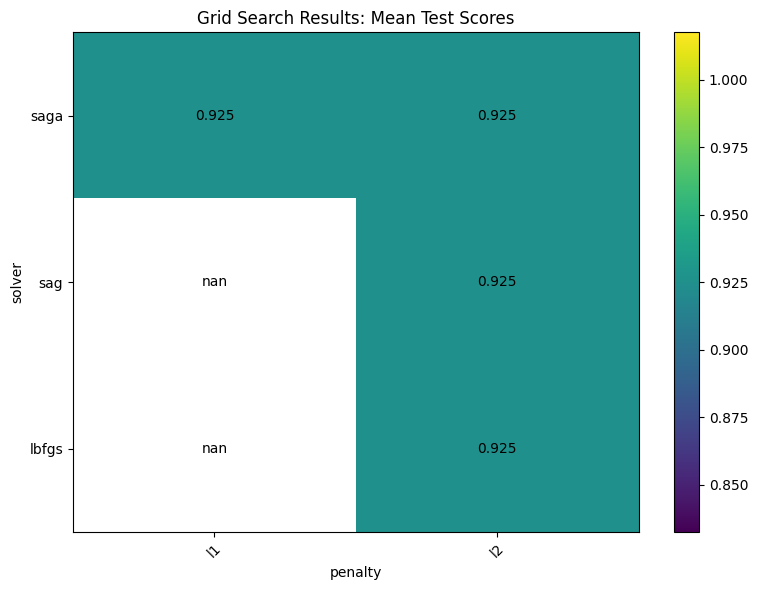

Best parameters: {'penalty': 'l1', 'solver': 'saga'}
Best score: 0.925


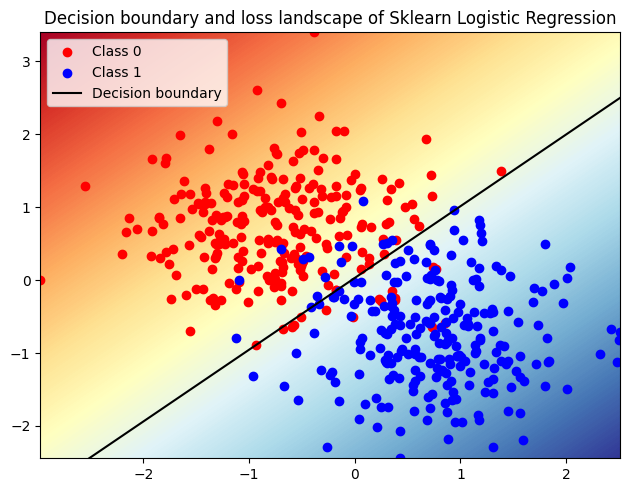

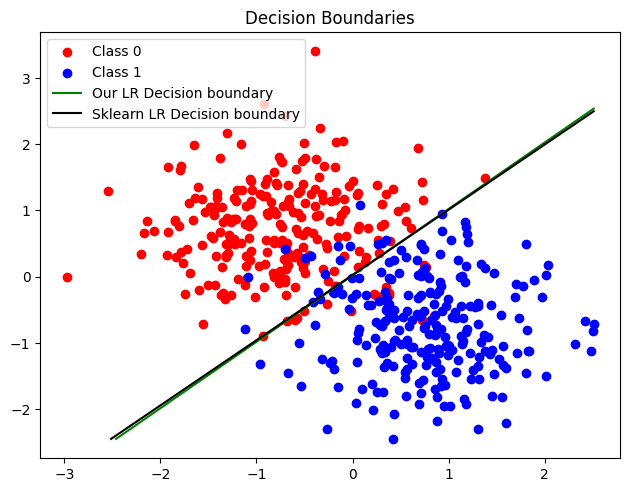

In [41]:
from sklearn.linear_model import LogisticRegression as LogisticRegressionSklearn
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

sklearn_classifier = LogisticRegressionSklearn(penalty=None, solver='sag', max_iter=1000)

sklearn_classifier.fit(X_train, y_train)

y_train_pred = sklearn_classifier.predict(X_train)
y_val_pred = sklearn_classifier.predict(X_val)

sk_LR_train_accuracy = np.mean(y_train_pred == y_train)
sk_LR_val_accuracy = np.mean(y_val_pred == y_val)

print(f"{'Model':<40} {'Train Accuracy':<20} {'Validation Accuracy':<20}")
print(f"{'-'*70}")
print(f"{'Our Logistic Regression model':<40} {LR_train_accuracy:<20.3f} {LR_val_accuracy:<20.3f}")
print(f"{'Our Gaussian Generative Model':<40} {GGM_train_accuracy:<20.3f} {GGM_val_accuracy:<20.3f}")
print(f"{'Sklearn Logistic Regression model':<40} {sk_LR_train_accuracy:<20.3f} {sk_LR_val_accuracy:<20.3f}")

cross_validator = KFold(n_splits=10)

grid_search_params = {
    'penalty' : ['l1', 'l2'],
    'solver' : ['saga', 'sag', 'lbfgs'],
}

param1_size = len(grid_search_params['penalty'])
param2_size = len(grid_search_params['solver'])

def score(classifier,x_test, y_true):
    y_pred = classifier.predict(x_test)
    return np.mean(y_true == y_pred)

grid_search = GridSearchCV(sklearn_classifier, grid_search_params, scoring=score, cv=cross_validator)
grid_search.fit(X_train, y_train)

scores = grid_search.cv_results_['mean_test_score'].reshape(param1_size, param2_size).T

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(scores, cmap='viridis', aspect='auto')
fig.colorbar(cax)
ax.set_xticks(np.arange(param1_size))
ax.set_yticks(np.arange(param2_size))
ax.set_xticklabels(grid_search_params['penalty'])
ax.set_yticklabels(grid_search_params['solver'])
plt.xticks(rotation=45)
for i in range(param2_size):
    for j in range(param1_size):
        ax.text(j, i, f'{scores[i, j]:.3f}', ha='center', va='center', color='black')
ax.set_xlabel('penalty')
ax.set_ylabel('solver')
ax.set_title('Grid Search Results: Mean Test Scores')
plt.tight_layout()
plt.show()

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


# Plotting landscape of the loss function and the decision boundary

w = sklearn_classifier.coef_[0]
b = sklearn_classifier.intercept_

grid_size = 100

x0_min, x0_max = X[:, 1].min(), X[:, 1].max()
x1_min, x1_max = X[:, 2].min(), X[:, 2].max()


def sklearn_get_w_and_b(classifier):
    return classifier.coef_[0], classifier.intercept_

sklearn_LR_decision_boundary = plot_loss_landscape(sklearn_classifier, X, y, sklearn_get_w_and_b, "Sklearn Logistic Regression", remove_column0_X=True)

plt.figure()
plt.scatter(X[:, 1][y == 0], X[:, 2][y == 0], color='red', label='Class 0')
plt.scatter(X[:, 1][y == 1], X[:, 2][y == 1], color='blue', label='Class 1')
plt.plot(LR_decision_boundary[:, 0], LR_decision_boundary[:, 1], color='green', label='Our LR Decision boundary')
plt.plot(sklearn_LR_decision_boundary[:, 0], sklearn_LR_decision_boundary[:, 1], color='black', label='Sklearn LR Decision boundary')
plt.tight_layout()
plt.legend()
plt.title("Decision Boundaries")
plt.show()


Scikit-learn doesn't offer the option to use the SGD solver, so we used the closest alternative, `sag`, a variant that includes some optimizations. This could explain the small difference between our model and theirs.

The difference in colors in the loss landscape is due to the fact that the `decision_function` method in the Scikit-learn model does not apply the sigmoid activation function before returning the results, whereas we chose to use it for better visualization.

The results of our method and Scikit-learn are very similar, both in terms of accuracy across the various training and validation sets and in their decision boundaries.

### 5. Application to breast cancer dataset

In [42]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()

**(Question)** Load the data into `X` and `y` variables. Familiarize yourself with this dataset. What are the dimensions? Explain what they mean.

X shape: (569, 30)
y shape: (569,)
y unique values: [0 1]

Names of the features (count: 30): ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Y values meanings: ['malignant' 'benign']


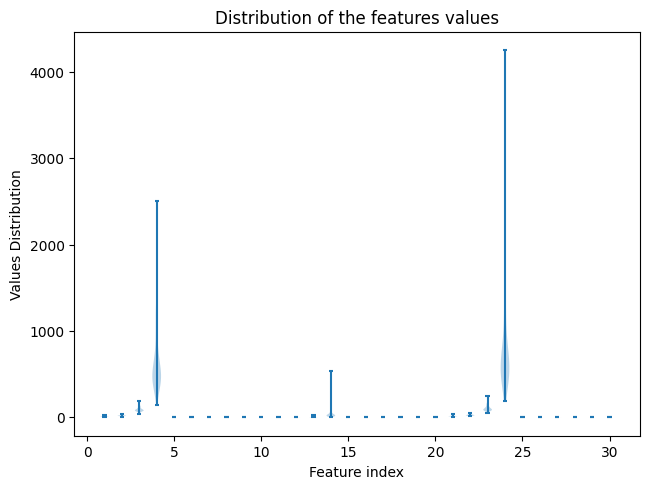

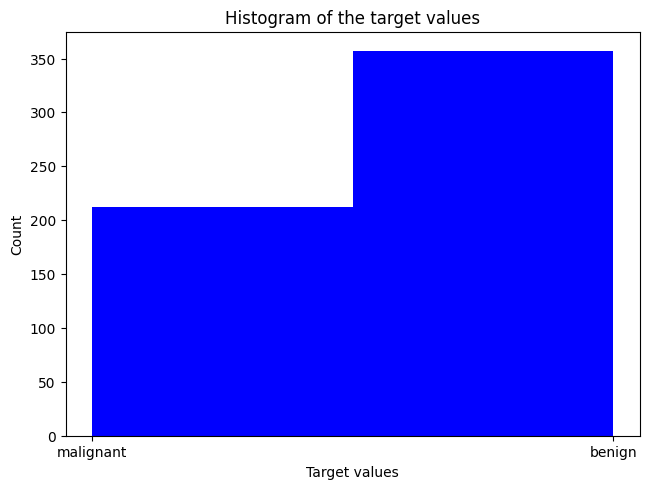

In [43]:
X = dataset.data
y = dataset.target

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"y unique values: {np.unique(y)}")
print("")
print(f"Names of the features (count: {len(dataset.feature_names)}): {dataset.feature_names}")
print(f"Y values meanings: {dataset.target_names}")

# plot violin plot of the features
plt.figure()
plt.violinplot(X)
plt.title("Distribution of the features values")
plt.tight_layout()
plt.xlabel('Feature index')
plt.ylabel('Values Distribution')
plt.show()

plt.figure()
plt.hist(y, bins=2, color='blue')
plt.title("Histogram of the target values")
plt.tight_layout()
plt.xlabel('Target values')
plt.ylabel('Count')
plt.xticks(np.unique(y), dataset.target_names)
plt.show()

assert np.all(np.unique(y) == np.array([0, 1]))

The dataset consists of a `data` element, representing the X features, and a `target` element, which is the prediction we aim to learn. The X features comprise 30 named variables, all represented by real values. However, since their ranges vary significantly, it is particularly important to normalize and standardize the data.

The target values are not balanced, as there are more benign elements than malignant elements, which could induce a bias in our models.

**(Question)** Split into train/test and preprocess the data.

In [44]:
train_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state=0)

X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)

X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

assert np.allclose(X_train.mean(axis=0), 0.)
assert np.allclose(X_train.var(axis=0), 1.)

Train size: 455
Test size: 114


**(Question)** Apply your implementations of logistic regression and gaussian generative model to this dataset.

Model                                    Train Accuracy  Test Accuracy  
----------------------------------------------------------------------
Our Logistic Regression model            0.97582         0.96491        
Our Gaussian Generative Model            0.96264         0.96491        


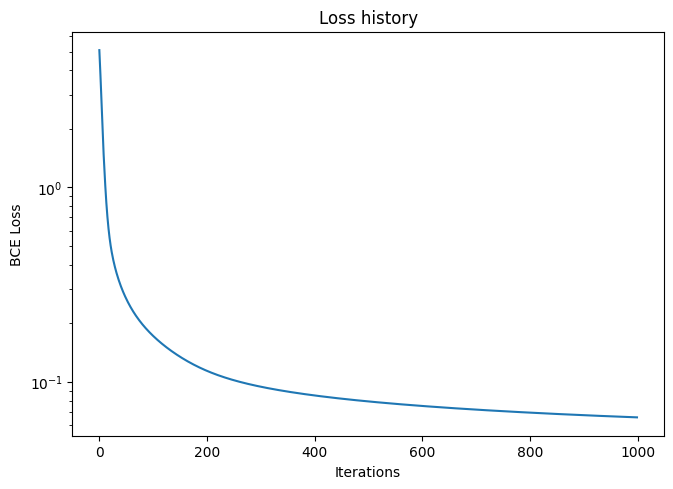

In [45]:

# Logistic Regression

LR_classifier = LogisticRegression()
LR_classifier.fit(X_train, y_train)

y_train_pred = LR_classifier.predict(X_train)
y_test_pred = LR_classifier.predict(X_test)

LR_train_accuracy = np.mean(y_train_pred == y_train)
LR_test_accuracy = np.mean(y_test_pred == y_test)


# Gaussian Generative Model

GGM_classifier = GaussianGenerativeModel()
GGM_classifier.fit(X_train, y_train)

y_train_pred = GGM_classifier.predict(X_train)
y_test_pred = GGM_classifier.predict(X_test)

GGM_train_accuracy = np.mean(y_train_pred == y_train)
GGM_test_accuracy = np.mean(y_test_pred == y_test)


# Summary of results

print(f"{'Model':<40} {'Train Accuracy':<15} {'Test Accuracy':<15}")
print(f"{'-'*70}")
print(f"{'Our Logistic Regression model':<40} {LR_train_accuracy:<15.5f} {LR_test_accuracy:<15.5f}")
print(f"{'Our Gaussian Generative Model':<40} {GGM_train_accuracy:<15.5f} {GGM_test_accuracy:<15.5f}")

plt.plot(LR_classifier.loss_hist)
plt.title("Loss history")
plt.tight_layout()
plt.yscale('log')
plt.ylabel("BCE Loss")
plt.xlabel("Iterations")
plt.show()

**(Question)** Apply cross-validation (see `sklearn.model_selection`) on your implementations to successively train several models and obtain predictions for the whole dataset.
Comment the results.

Model                                              Train Accuracy  Test Accuracy  
--------------------------------------------------------------------------------
Our Logistic Regression model (no cross-val)       0.976           0.965          
Our Logistic Regression model (10 KFold)           0.990           0.972          
Our Gaussian Generative Model (no cross-val)       0.963           0.965          
Our Gaussian Generative Model (10 KFold)           0.965           0.954          


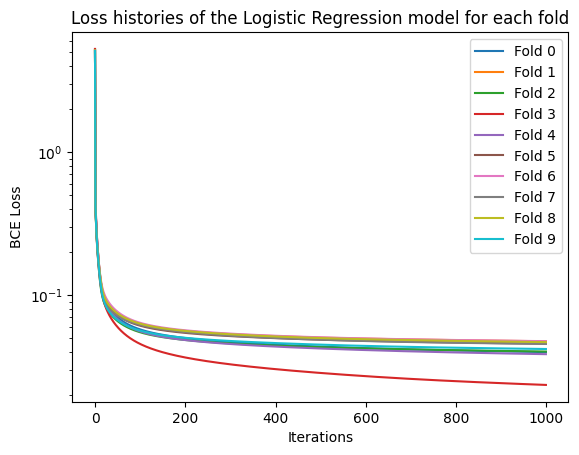

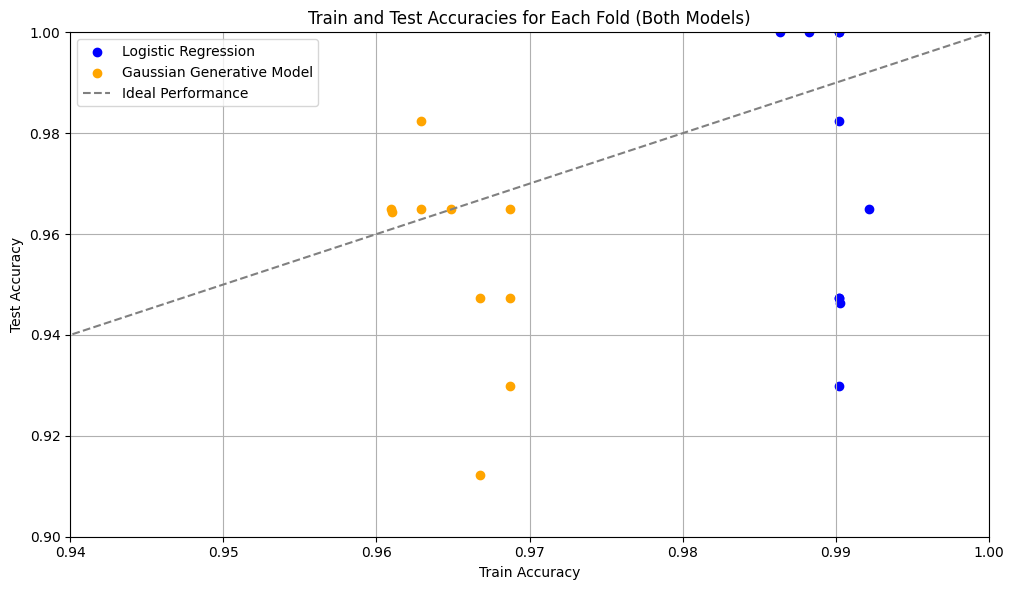

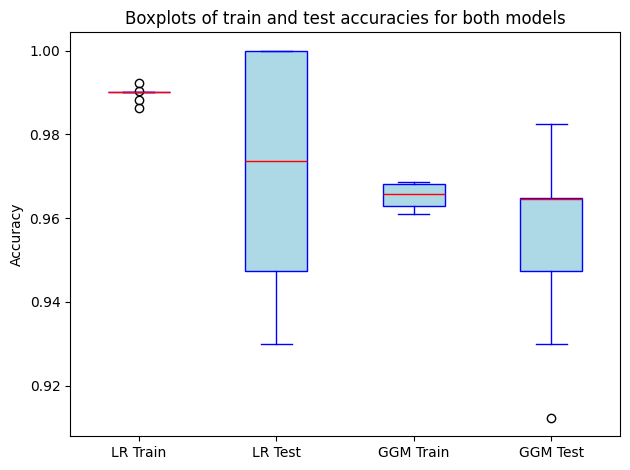

In [46]:
from sklearn.model_selection import KFold, GroupKFold, cross_val_score

def get_cross_val_score(classifier_class, kwargs, X, y, kf, get_loss_history=False):
    train_accuracies = []
    test_accuracies = []
    loss_histories = []

    for train_index, test_index in kf.split(X, y):
        classifier = classifier_class(**kwargs)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        classifier.fit(X_train, y_train)

        y_train_pred = classifier.predict(X_train)
        y_test_pred = classifier.predict(X_test)

        train_accuracy = np.mean(y_train_pred == y_train)
        test_accuracy = np.mean(y_test_pred == y_test)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        if get_loss_history:
            loss_histories.append([classifier.loss_hist])

    return train_accuracies, test_accuracies, loss_histories

LR_classifier = LogisticRegression()
GGM_classifier = GaussianGenerativeModel()

kf = KFold(n_splits=10, shuffle=False)
# kf = GroupKFold(n_splits=5)

X_whole = np.vstack([X_train, X_test])
y_whole = np.hstack([y_train, y_test])

kwargs = {'learning_rate': 1.5, 'n_iters': 1000}
LR_kf_train_accuracies, LR_kf_test_accuracies, LR_loss_histories = get_cross_val_score(LogisticRegression, kwargs, X_whole, y_whole, kf, get_loss_history=True)
kwargs = {}
GGM_kf_train_accuracies, GGM_kf_test_accuracies, _ = get_cross_val_score(GaussianGenerativeModel, kwargs, X_whole, y_whole, kf)

print(f"{'Model':<50} {'Train Accuracy':<15} {'Test Accuracy':<15}")
print(f"{'-'*80}")
print(f"{'Our Logistic Regression model (no cross-val)':<50} {LR_train_accuracy:<15.3f} {LR_test_accuracy:<15.3f}")
print(f"{'Our Logistic Regression model (10 KFold)':<50} {np.mean(LR_kf_train_accuracies):<15.3f} {np.mean(LR_kf_test_accuracies):<15.3f}")
print(f"{'Our Gaussian Generative Model (no cross-val)':<50} {GGM_train_accuracy:<15.3f} {GGM_test_accuracy:<15.3f}")
print(f"{'Our Gaussian Generative Model (10 KFold)':<50} {np.mean(GGM_kf_train_accuracies):<15.3f} {np.mean(GGM_kf_test_accuracies):<15.3f}")


plt.figure()
plt.title("Loss histories of the Logistic Regression model for each fold")
for i, loss_history in enumerate(LR_loss_histories):
    plt.plot(loss_history[0], label=f"Fold {i}")
plt.yscale('log')
plt.ylabel("BCE Loss")
plt.xlabel("Iterations")
plt.legend()
plt.show()


# Plotting train and test accuracies for both models in a 2D plot
plt.figure(figsize=(10, 6))
plt.scatter(LR_kf_train_accuracies, LR_kf_test_accuracies, label='Logistic Regression', color='blue')
plt.scatter(GGM_kf_train_accuracies, GGM_kf_test_accuracies, label='Gaussian Generative Model', color='orange')
max_accuracy = max(max(LR_kf_test_accuracies), max(GGM_kf_test_accuracies))
plt.plot([0, max_accuracy], [0, max_accuracy], linestyle='--', color='gray', label='Ideal Performance')
plt.xlabel("Train Accuracy")
plt.ylabel("Test Accuracy")
plt.title("Train and Test Accuracies for Each Fold (Both Models)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.xlim(0.94, 1) 
plt.ylim(0.90, 1)
plt.show()

# Doing the same thing but with boxplots

plt.figure()
plt.boxplot(
    [LR_kf_train_accuracies, LR_kf_test_accuracies, GGM_kf_train_accuracies, GGM_kf_test_accuracies],
    tick_labels=['LR Train', 'LR Test', 'GGM Train', 'GGM Test'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue')
)
plt.title("Boxplots of train and test accuracies for both models")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

Thanks to the cross-validation approach, we can more confidently evaluate the performance of our models. We trained and tested 10 different models for both the Logistic Regressor and the Gaussian Generative models, covering the entire dataset. This provides us with average scores for both the training and testing sets. The results show that, overall, the Logistic Regressor tends to overfit the data more than the Gaussian Generative model. However, despite the overfitting, the Logistic Regressor still achieves the highest accuracy on the test set (0.972 versus 0.954).

**Bonus**: Comparing for different PCA reductions dimensions

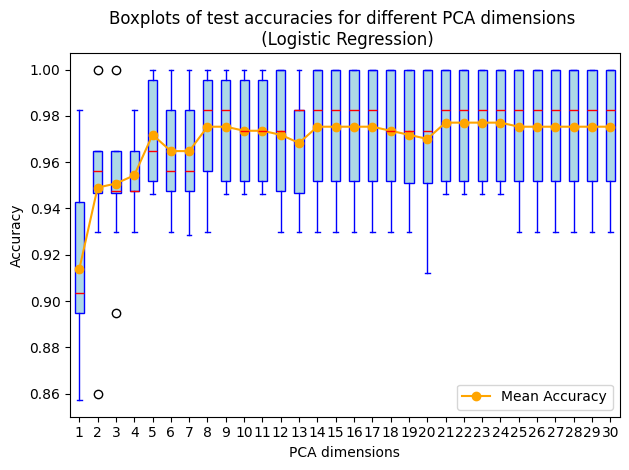

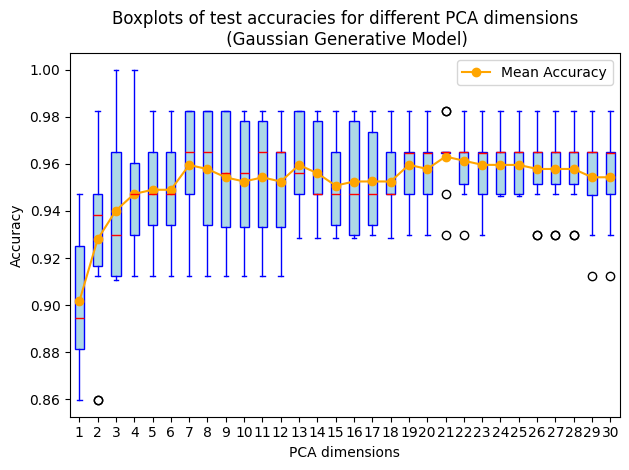

In [47]:
from sklearn.decomposition import PCA

pca_dimensions = np.arange(1, X.shape[1] + 1)

LR_kf_train_accuracies, LR_kf_test_accuracies, LR_loss_histories = [], [], []
GMM_kf_train_accuracies, GMM_kf_test_accuracies = [], []

kf = KFold(n_splits=10, shuffle=False)

for pca_dim in pca_dimensions:
    pca = PCA(n_components=pca_dim)
    X_pca = pca.fit_transform(X_whole)

    kwargs = {'learning_rate': 1.5, 'n_iters': 1000}
    train_accuracies, test_accuracies, _ = get_cross_val_score(LogisticRegression, kwargs, X_pca, y_whole, kf)
    kwargs = {}
    GMM_train_accuracies, GMM_test_accuracies, _ = get_cross_val_score(GaussianGenerativeModel, kwargs, X_pca, y_whole, kf)

    LR_kf_train_accuracies.append(train_accuracies)
    LR_kf_test_accuracies.append(test_accuracies)
    GMM_kf_train_accuracies.append(GMM_train_accuracies)
    GMM_kf_test_accuracies.append(GMM_test_accuracies)

LR_kf_means = [np.mean(accuracies) for accuracies in LR_kf_test_accuracies]
GMM_kf_means = [np.mean(accuracies) for accuracies in GMM_kf_test_accuracies]

plt.figure()
plt.boxplot(
    LR_kf_test_accuracies,
    tick_labels=[f"{dim}" for dim in pca_dimensions],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue')
)
plt.plot(pca_dimensions, LR_kf_means, marker='o', color='orange', linestyle='-', label='Mean Accuracy')
plt.title("Boxplots of test accuracies for different PCA dimensions \n (Logistic Regression)")
plt.xlabel("PCA dimensions")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend()
plt.show()

plt.figure()
plt.boxplot(
    GMM_kf_test_accuracies,
    tick_labels=[f"{dim}" for dim in pca_dimensions],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue')
)
plt.plot(pca_dimensions, GMM_kf_means, marker='o', color='orange', linestyle='-', label='Mean Accuracy')
plt.title("Boxplots of test accuracies for different PCA dimensions\n (Gaussian Generative Model)")
plt.xlabel("PCA dimensions")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend()
plt.show()

We can observe that many of the features appear to be correlated. In fact, both models achieve similar performance whether using the full set of 30 features or 10 to 15 features obtained through PCA dimensionality reduction. By reducing the number of features in the dataset, it is possible to run predictions faster while still benefiting from equivalent performance compared to using all the features.

**Bonus:** Attempting to make a Gaussian model misclassify a dataset with blobs of different covariance matrices.

X shape: (500, 2)
y shape: (500,)
y unique values: [0 1]


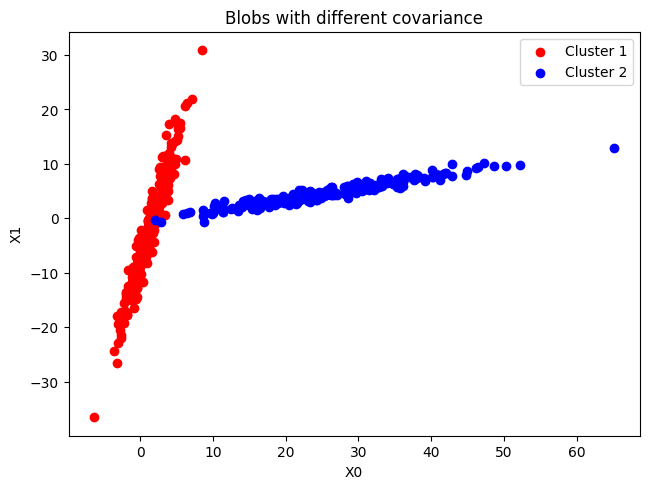

In [48]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate dataset with different covariance (standard deviation) for each cluster
X0, y0 = make_blobs(n_samples=250, n_features=2, centers=1, center_box=(-3, 3), random_state=42)
X1, y1 = make_blobs(n_samples=250, n_features=2, centers=1, center_box=(-3, 3), random_state=42)

# Define a transformation matrix to stretch the blobs
transformation_matrix0 = np.array([[2.0, 10],   # Stretch along x and tilt
                                  [1, 2.0]])  # Stretch along y
transformation_matrix1 = np.array([[2.0, 1],
                                  [10, 2.0]])

# Apply the transformation to the data
X0_transformed = X0 @ transformation_matrix0 
X1_transformed = X1 @ transformation_matrix1

X_transformed = np.vstack((X0_transformed, X1_transformed))
y = np.hstack((y0, np.ones_like(y1)))

indices = np.random.permutation(X_transformed.shape[0])

X = X_transformed[indices]
y = y[indices]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"y unique values: {np.unique(y)}")

# Visualizing the blobs
plt.figure()
plt.title("Blobs with different covariance")
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], color='red', label='Cluster 1')
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], color='blue', label='Cluster 2')
plt.tight_layout()
plt.legend()
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

In [49]:
# We will use cross-validation to evaluate the models and no test set because this is a toy example
X = (X - X.mean(axis=0)) / X.std(axis=0)

assert np.allclose(X.mean(axis=0), 0.)
assert np.allclose(X.var(axis=0), 1.)

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

Applying our Gaussian Generative Model with the covariance matrix hypothesis:

In [50]:
kf = KFold(n_splits=20, shuffle=False)
kwargs = {}
GGM_train_accuracies, GGM_val_accuracies, _ = get_cross_val_score(GaussianGenerativeModel, kwargs, X, y, kf)
GGM_train_accuracy = np.mean(GGM_train_accuracies)
GGM_val_accuracy = np.mean(GGM_val_accuracies)

print(f"{'Model':<40} {'Train Accuracy':<20} {'Validation Accuracy':<20}")
print(f"{'-'*70}")
print(f"{'Our Gaussian Generative Model (20 KFold)':<40} {GGM_train_accuracy:<20.3f} {GGM_val_accuracy:<20.3f}")

Model                                    Train Accuracy       Validation Accuracy 
----------------------------------------------------------------------
Our Gaussian Generative Model (20 KFold) 0.948                0.948               


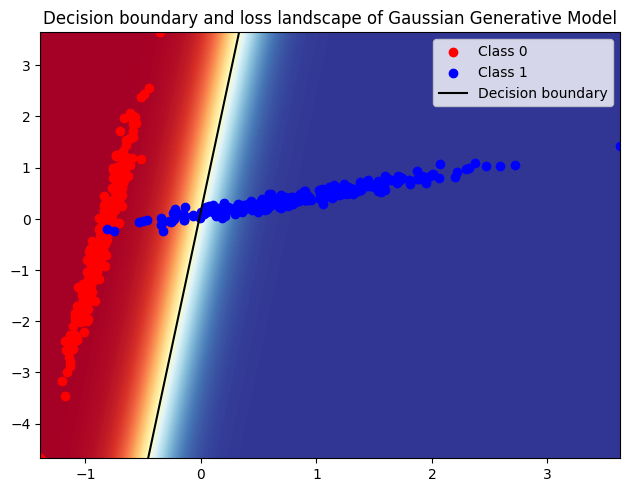

In [51]:
# Plot the decision boundaries of the Gaussian Generative Model
def GMM_get_w_and_b(classifier):
    return classifier.w, classifier.b

GGM_classifier = GaussianGenerativeModel()
GGM_classifier.fit(X_train, y_train)

grid_size = 100
GGM_decision_boundary = plot_loss_landscape(GGM_classifier, X, y, GMM_get_w_and_b, "Gaussian Generative Model",remove_column0_X=True, no_ones=True)

Model                                              Train Accuracy  Validation Accuracy
--------------------------------------------------------------------------------
Our Logistic Regression model (20 KFold)           0.991           0.967          
Our Gaussian Generative Model (20 KFold)           0.948           0.948          


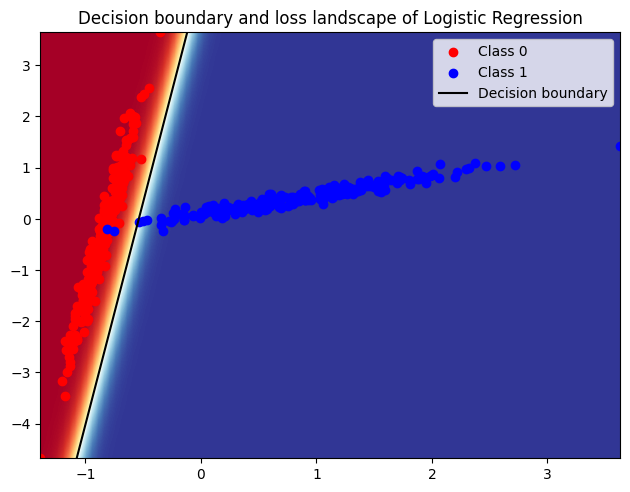

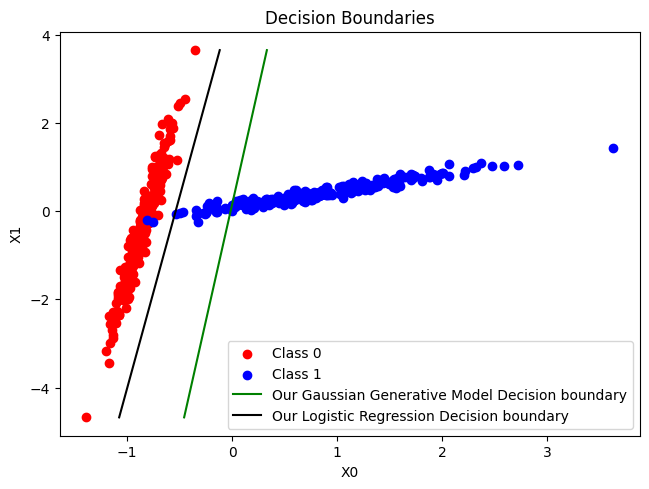

In [52]:
kf = KFold(n_splits=20, shuffle=False)
kwargs = {'learning_rate': 10, 'n_iters': 1000}
LR_train_accuracies, LR_val_accuracies, _ = get_cross_val_score(LogisticRegression, kwargs, X_whole, y_whole, kf)
LR_train_accuracy = np.mean(LR_train_accuracies)
LR_val_accuracy = np.mean(LR_val_accuracies)

print(f"{'Model':<50} {'Train Accuracy':<15} {'Validation Accuracy':<15}")
print(f"{'-'*80}")
print(f"{'Our Logistic Regression model (20 KFold)':<50} {LR_train_accuracy:<15.3f} {LR_val_accuracy:<15.3f}")
print(f"{'Our Gaussian Generative Model (20 KFold)':<50} {GGM_train_accuracy:<15.3f} {GGM_val_accuracy:<15.3f}")


# Plot the decision boundaries of the Logistic Regression  Model
lr_classifier = LogisticRegression(n_iters=1000, learning_rate=10)
X_train_with_zero = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
lr_classifier.fit(X_train_with_zero, y_train)
LR_decision_boundary = plot_loss_landscape(lr_classifier, X, y, LR_get_w_and_b, "Logistic Regression", no_ones=True)

# Compare the decision boundaries of the Logistic Regression and Gaussian Generative Models
plt.figure()
plt.title("Decision Boundaries")
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], color='red', label='Class 0')
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], color='blue', label='Class 1')
plt.plot(GGM_decision_boundary[:, 0], GGM_decision_boundary[:, 1], color='green', label='Our Gaussian Generative Model Decision boundary')
plt.plot(LR_decision_boundary[:, 0], LR_decision_boundary[:, 1], color='black', label='Our Logistic Regression Decision boundary')
plt.tight_layout()
plt.legend()
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()


For our GGM to work properly, we need to assume that class 1 has the same covariance matrix as class 0, meaning they share the same shape. However, this assumption is incorrect in this case. When comparing the decision boundaries of our GGM model to those of our Logistic Regression model, it is clear that the Logistic Regression model performs better for this problem. It also has higher accuracy on the test dataset, with 96.7% compared to 94.8% for the GGM.